<a href="https://colab.research.google.com/github/gauravshelangia/intro-to-ml-tensorflow/blob/master/projects/p2_image_classifier/Project_Image_Classifier_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Your First AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories, you can see a few examples below. 

<img src='https://github.com/gauravshelangia/intro-to-ml-tensorflow/blob/master/projects/p2_image_classifier/assets/Flowers.png?raw=1' width=500px>

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use your trained model to perform inference on flower images.

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

## Import Resources

In [0]:
# TODO: Make all necessary imports.
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from google.colab import files
import json
import numpy as np
from tensorflow.python.framework.ops import enable_eager_execution


In [167]:
# !pip install tensorflow==1.15.0
# !pip install keras==2.2.5
print(tf.__version__)

1.15.0


## Load the Dataset

Here you'll use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  You'll also need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but you'll still need to normalize and resize the images to the appropriate size.

In [0]:
# TODO: Load the dataset with TensorFlow Datasets.
dataset, info = tfds.load('oxford_flowers102', as_supervised=True, with_info=True)
# TODO: Create a training set, a validation set and a test set.
train_data, test_data, validation_data = dataset['train'], dataset['test'], dataset['validation']

In [0]:
tf.enable_eager_execution()

In [0]:
IMAGE_SIZE=224
BATCH_SIZE=20

## Resize image function
def resize_image(image, label):
  # print("Image Type = ",type(image))
  # print("Input shape  =", image.shape)
  # print("label =", label)
  target_size = [IMAGE_SIZE,IMAGE_SIZE]
  resized_image = tf.image.resize_images(image,target_size)
  # print("Shape resize = ", resized_image.shape)
  return resized_image,label

In [0]:
# resize train data
train_data = train_data.map(resize_image)
# resize validation data
validation_data = validation_data.map(resize_image)
# resize test data
test_data = test_data.map(resize_image)

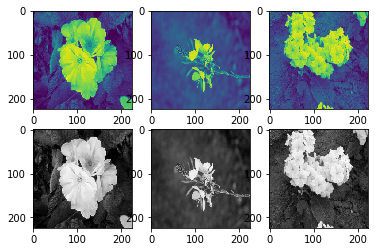

In [171]:
fig, axs = plt.subplots(2,3)
for image,label in train_data.take(1):
    axs[0, 0].imshow(image.numpy()[:, :, 0].astype(np.float32))
    axs[1, 0].imshow(image.numpy()[:, :, 0].astype(np.float32), cmap=plt.get_cmap("gray"))

for image,label in test_data.take(1):
    axs[0, 1].imshow(image.numpy()[:, :, 0].astype(np.float32))
    axs[1, 1].imshow(image.numpy()[:, :, 0].astype(np.float32), cmap=plt.get_cmap("gray"))

for image,label in validation_data.take(1):
    axs[0, 2].imshow(image.numpy()[:, :, 0].astype(np.float32))
    axs[1, 2].imshow(image.numpy()[:, :, 0].astype(np.float32), cmap=plt.get_cmap("gray"))



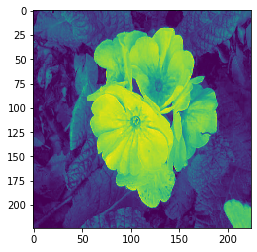

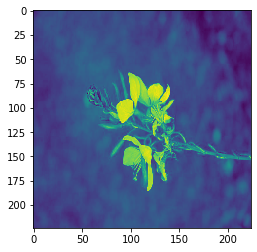

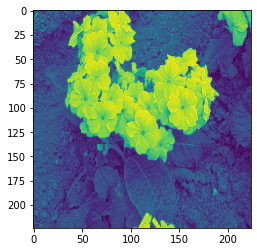

In [172]:
for image,label in train_data.take(1):
    plt.figure(1)
    plt.imshow(image.numpy()[:, :, 0].astype(np.float32))

for image,label in test_data.take(1):
    plt.figure(2)
    plt.imshow(image.numpy()[:, :, 0].astype(np.float32))

for image,label in validation_data.take(1):
    plt.figure(3)
    plt.imshow(image.numpy()[:, :, 0].astype(np.float32))

In [173]:
# Verification that reshape has done
for image, label in train_data.take(1):
  print(image.shape)

(224, 224, 3)


## Explore the Dataset

In [174]:
# TODO: Get the number of examples in each set from the dataset info.
print("Number of training examples = ",info.splits['train'].num_examples)
print("Number of test examples = ",info.splits['test'].num_examples)
print("Number of validation examples = ",info.splits['validation'].num_examples)
# TODO: Get the number of classes in the dataset from the dataset info.
print("Number of Classess = ",info.features['label'].num_classes)


Number of training examples =  1020
Number of test examples =  6149
Number of validation examples =  1020
Number of Classess =  102


In [175]:
# TODO: Print the shape and corresponding label of 3 images in the training set.
for image, label in train_data.take(3):
  print("shape of trainig example = ", image.shape)
  print("Label of image = ")
  tf.print(label)

shape of trainig example =  (224, 224, 3)
Label of image = 
52
shape of trainig example =  (224, 224, 3)
Label of image = 
60
shape of trainig example =  (224, 224, 3)
Label of image = 
52


Label of image =  52


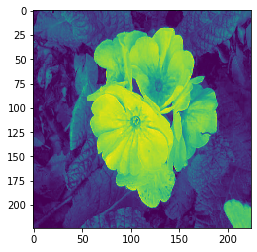

In [176]:
# TODO: Plot 1 image from the training set. Set the title 
# of the plot to the corresponding image label. 
for image, label in train_data.take(1):
  print("Label of image = ", label.numpy())
  plt.imshow(image.numpy()[:, :, 0].astype(np.float32))



### Label Mapping

You'll also need to load in a mapping from label to category name. You can find this in the file `label_map.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give you a dictionary mapping the integer coded labels to the actual names of the flowers.

In [14]:
from google.colab import files
uploaded = files.upload()


Saving label_map.json to label_map.json


In [0]:
with open('label_map.json', 'r') as f:
    class_names = json.load(f)

In [178]:
#Dry run test
class_names["52"]


'wild pansy'

Label =  52
Class Name =  wild pansy


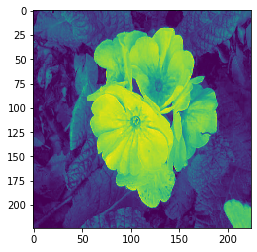

In [179]:
# TODO: Plot 1 image from the training set. Set the title 
# of the plot to the corresponding class name. 
for image,label in train_data.take(1):
  plt.imshow(image.numpy()[:, :, 0].astype(np.float32))
  print("Label = ", label.numpy())
  print("Class Name = ", class_names.get(str(label.numpy())))


In [180]:
type(train_data)

tensorflow.python.data.ops.dataset_ops.DatasetV1Adapter

## Create Pipeline

In [0]:
# TODO: Create a pipeline for each set.
# Resize of all the split has been done already
# Steps are 
# 1. Resize all splits image to one comman shape ([224,224,3] is our shape)
# 2. Batch all the training data


#  create batch of training data
train_data = train_data.repeat().batch(BATCH_SIZE)
train_data = train_data.prefetch(tf.data.experimental.AUTOTUNE)

# validation set batch size can be set as training set
validation_data = validation_data.repeat().batch(BATCH_SIZE)
validation_data = validation_data.prefetch(tf.data.experimental.AUTOTUNE)

#  Making batch size 1 as to avoid making less or more prediction
test_data = test_data.repeat().batch(1)
test_data = test_data.prefetch(tf.data.experimental.AUTOTUNE)


In [182]:
# verify batch has been applied
for image, label in train_data.take(1):
  print(image.shape)
  print(label.shape)

for image, label in test_data.take(1):
  print(image.shape)
  print(label.shape)

for image, label in validation_data.take(1):
  print(image.shape)
  print(label.shape)

(20, 224, 224, 3)
(20,)
(1, 224, 224, 3)
(1,)
(20, 224, 224, 3)
(20,)


# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. You should use the MobileNet pre-trained model from TensorFlow Hub to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! 

Refer to the rubric for guidance on successfully completing this section. Things you'll need to do:

* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training for the training and validation set.
* Save your trained model as a Keras model. 

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right.

**Note for Workspace users:** One important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module. Also, If your model is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [0]:
# TODO: Build and train your network.
# IMAGE_SIZE=224 # alreay defined
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=INPUT_SHAPE, include_top=False, weights='imagenet')

In [184]:
# more readability
train_batches = train_data

for image_batch, label_batch in train_batches.take(1):
   pass
   
image_batch.shape

TensorShape([Dimension(20), Dimension(224), Dimension(224), Dimension(3)])

In [185]:
# lets see what feature base model extracts
feature_batch = base_model(image_batch)
print(feature_batch.shape)


(20, 7, 7, 1280)


In [0]:
# Freez the training of base model
base_model.trainable = False

# Let's take a look at the base model architecture
# base_model.summary()


In [0]:
# create a average pooling layer
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# add prediction/output layer
prediction_layer = tf.keras.layers.Dense(1)


# Create the new model with stacking up the modes and layers we have
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [188]:
# Feature extraction or shape change on global pooling layer
feature_batch_average = global_average_layer(feature_batch)
print("Global Pooling layer = ", global_average_layer(feature_batch).shape)
print("Dense layer Features = ", prediction_layer(feature_batch).shape)


Global Pooling layer =  (20, 1280)
Dense layer Features =  (20, 7, 7, 1)


In [0]:
# Define a learning rate and add optimizers and metric to the model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])


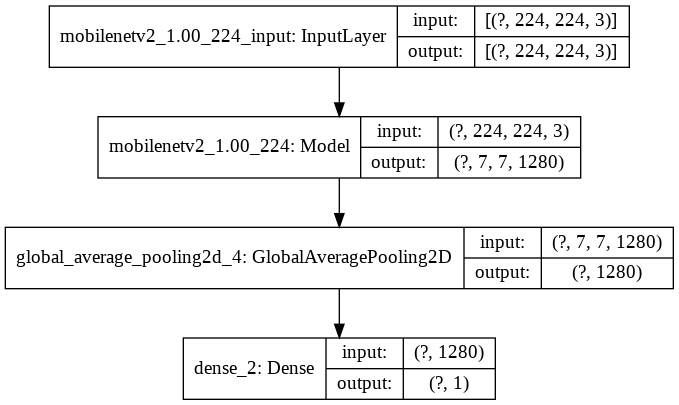

In [190]:
# Below short codde can be used to visualize the model
from tensorflow.keras.utils import plot_model
from IPython.display import Image

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
Image("model.png")

In [191]:
# You can aslo see the sumary of model here
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [192]:
# Lets see how many trainable variables we have at this moment.
len(model.trainable_variables)


2

In [196]:
num_train = info.splits['train'].num_examples
num_validation = info.splits['validation'].num_examples
initial_epochs = 10
steps_per_epoch = round(num_train)//BATCH_SIZE
validation_steps = num_validation//BATCH_SIZE

validation_batches = validation_data

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

51/51 [==============================] - 4s 85ms/step - loss: -754.8373 - acc: 0.0098


In [197]:
# Lets take a not of initial accuracy
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))


initial loss: -754.84
initial accuracy: 0.01


In [198]:
# Now, train the newly created model
history = model.fit(train_batches,
                    epochs=initial_epochs, steps_per_epoch=steps_per_epoch,
                    validation_data=validation_batches,validation_steps=validation_steps)


Train for 51 steps, validate for 51 steps
Epoch 1/10
51/51 [==============================] - 10s 192ms/step - loss: -753.6094 - acc: 0.0098 - val_loss: -754.8373 - val_acc: 0.0098
Epoch 2/10
51/51 [==============================] - 7s 143ms/step - loss: -753.6504 - acc: 0.0098 - val_loss: -754.8373 - val_acc: 0.0098
Epoch 3/10
51/51 [==============================] - 7s 139ms/step - loss: -753.7043 - acc: 0.0098 - val_loss: -754.8373 - val_acc: 0.0098
Epoch 4/10
51/51 [==============================] - 8s 156ms/step - loss: -753.8016 - acc: 0.0098 - val_loss: -754.8373 - val_acc: 0.0098
Epoch 5/10
51/51 [==============================] - 7s 133ms/step - loss: -754.8507 - acc: 0.0098 - val_loss: -754.8373 - val_acc: 0.0098
Epoch 6/10
51/51 [==============================] - 7s 137ms/step - loss: -754.8508 - acc: 0.0098 - val_loss: -754.8373 - val_acc: 0.0098
Epoch 7/10
51/51 [==============================] - 7s 136ms/step - loss: -753.9845 - acc: 0.0098 - val_loss: -754.8373 - val_acc

train loss =  [-753.6093893612133, -753.6504289215686, -753.7043229645374, -753.8015759037991, -754.8506709080117, -754.8508384554993, -753.9844617656632, -754.8511244829963, -754.8512010761336, -754.851302801394]
train loss =  [-754.8372766831342, -754.8372766831342, -754.8372766831342, -754.8372766831342, -754.8372766831342, -754.8372766831342, -754.8372766831342, -754.8372766831342, -754.8372766831342, -754.8372766831342]


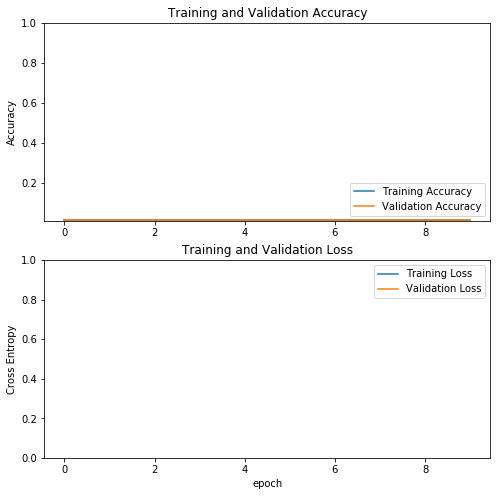

In [202]:
# TODO: Plot the loss and accuracy values achieved during training for the training and validation set.
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']
print("train loss = ", loss)
print("train loss = ", val_loss)
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


## Testing your Network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [0]:
# TODO: Print the loss and accuracy values achieved on the entire test set.
test_batches = test_data
num_test = info.splits['test'].num_examples
predictions = model.predict(test_batches,steps=num_test)


In [213]:
print(predictions[1])

[3.811896]


## Save the Model

Now that your network is trained, save the model so you can load it later for making inference. In the cell below save your model as a Keras model (*i.e.* save it as an HDF5 file).

In [0]:
# TODO: Save your trained model as a Keras model.



## Load the Keras Model

Load the Keras model you saved above.

In [0]:
# TODO: Load the Keras model



# Inference for Classification

Now you'll write a function that uses your trained network for inference. Write a function called `predict` that takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

The `predict` function will also need to handle pre-processing the input image such that it can be used by your model. We recommend you write a separate function called `process_image` that performs the pre-processing. You can then call the `process_image` function from the `predict` function. 

### Image Pre-processing

The `process_image` function should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

First, you should convert your image into a TensorFlow Tensor and then resize it to the appropriate size using `tf.image.resize`.

Second, the pixel values of the input images are typically encoded as integers in the range 0-255, but the model expects the pixel values to be floats in the range 0-1. Therefore, you'll also need to normalize the pixel values. 

Finally, convert your image back to a NumPy array using the `.numpy()` method.

In [0]:
# TODO: Create the process_image function



To check your `process_image` function we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by your `process_image` function. If your `process_image` function works, the plotted image should be the correct size. 

In [0]:
from PIL import Image

image_path = './test_images/hard-leaved_pocket_orchid.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

Once you can get images in the correct format, it's time to write the `predict` function for making inference with your model.

### Inference

Remember, the `predict` function should take an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

**Note:** The image returned by the `process_image` function is a NumPy array with shape `(224, 224, 3)` but the model expects the input images to be of shape `(1, 224, 224, 3)`. This extra dimension represents the batch size. We suggest you use the `np.expand_dims()` function to add the extra dimension. 

In [0]:
# TODO: Create the predict function



# Sanity Check

It's always good to check the predictions made by your model to make sure they are correct. To check your predictions we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

In the cell below use `matplotlib` to plot the input image alongside the probabilities for the top 5 classes predicted by your model. Plot the probabilities as a bar graph. The plot should look like this:

<img src='https://github.com/gauravshelangia/intro-to-ml-tensorflow/blob/master/projects/p2_image_classifier/assets/inference_example.png?raw=1' width=600px>

You can convert from the class integer labels to actual flower names using `class_names`. 

In [0]:
# TODO: Plot the input image along with the top 5 classes
